# Generative Sentiments NLP Model

This notebook inplements a bidirectional LSTM model used to classify an emotional sentence into one of 6 emotions:
- Anger
- Sadness
- Joy
- Fear
- Surprise
- Love

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv("data/train.txt", delimiter=';', header=None, names=['sentence','label'])

In [3]:
train_df.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


<AxesSubplot:xlabel='label', ylabel='count'>

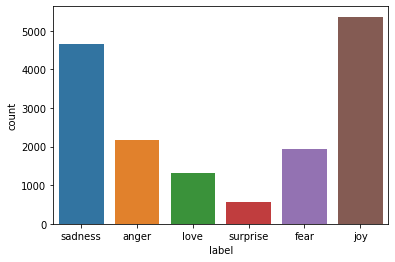

In [4]:
sns.countplot(train_df['label'])

In [5]:
MAX_LENGTH = 100 # max length of any input sentance in the data
MAX_WORDS = 20000

## Preprocessing

In [6]:
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/taylorarnett/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
def clean_stopwords(text):
    """
    remove simple words that don't help understand the sentiment all that well
    """
    return [word for word in text.split() if word.lower() not in stopwords.words('english')]

In [8]:
text = train_df['sentence'].apply(clean_stopwords)

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [33]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(text) 

In [34]:
#save tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
def pad_and_tokenize(text):
    sequences = tokenizer.texts_to_sequences(text)

    data = pad_sequences(sequences, maxlen=MAX_LENGTH)
    
    return data


In [12]:
X = pad_and_tokenize(text)
X.shape # expecting (16000, 100)

(16000, 100)

## Generate Y Data

In [13]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [14]:
def encode_y_data(train_df):
    encoder = LabelEncoder()
    
    y = encoder.fit_transform(train_df['label'])
    y_data = np_utils.to_categorical(y)
    
    # save the encoded classes so we can decode later on
    np.save('classes.npy', encoder.classes_)
    
    return y_data

In [15]:
Y = encode_y_data(train_df)
Y.shape # expecting (16000, 6) because we have 6 labels
Y

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

## Split train and test sets

In [16]:
X_train= X[:13000]  # TODO change ratios
Y_train= Y[:13000]
X_test= X[13000:]
Y_test= Y[13000:]

## Build Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Dense, Bidirectional, LSTM

In [18]:
def model(Y):
    model = Sequential()
    
    model.add(Embedding(MAX_WORDS, 64, input_length=MAX_LENGTH))
    
    model.add(Bidirectional(LSTM(128)))
    
    model.add(Dropout(0.7))
    
    model.add(Dense(32, activation='relu'))
    
    model.add(Dense(Y.shape[1], activation='softmax'))
    
    return model
    

In [19]:
model = model(Y)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                8224      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 1,486,054
Trainable params: 1,486,054
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Train the model

In [21]:
# use an early stopper for performance
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
early_stopper = EarlyStopping(monitor='val_loss')

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5, callbacks=[early_stopper])

Epoch 1/5
407/407 [==============================] - 42s 103ms/step - loss: 1.3638 - accuracy: 0.4274 - val_loss: 0.8215 - val_accuracy: 0.7253
Epoch 2/5
407/407 [==============================] - 42s 103ms/step - loss: 0.5599 - accuracy: 0.8089 - val_loss: 0.3446 - val_accuracy: 0.8843
Epoch 3/5
407/407 [==============================] - 41s 100ms/step - loss: 0.2176 - accuracy: 0.9295 - val_loss: 0.2955 - val_accuracy: 0.9030
Epoch 4/5
407/407 [==============================] - 40s 99ms/step - loss: 0.1236 - accuracy: 0.9590 - val_loss: 0.3017 - val_accuracy: 0.9073


## Prediction Utils

In [31]:
def predict(sentence):
    """
    takes an english sentance and uses the trained model to predict the emotion
    """
    input_sentence = np.array([sentence])
    tokenized_sentence = pad_and_tokenize(input_sentence)
    print(repr(tokenized_sentence))
    
    # pass tokenized sentence to trained model
    prediction = model.predict(tokenized_sentence)
#     print(prediction)
    
    confidence = np.max(prediction)
    label_idx = np.argmax(prediction)
    print(label_idx)
    
    result = np.array([label_idx])
    
    # load the saved encoder classes so we can decode the label properly
    encoder = LabelEncoder()
    encoder.classes_ = np.load('classes.npy', allow_pickle=True)
    
    label = encoder.inverse_transform(result)
    
    return label[0], confidence

## Manually Testing

In [32]:
sentence = 'I feel inspired'
label, confidence = predict(sentence)
print(f'Label: {label}')
print(f'Confidence: {confidence}')

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   1, 347]], dtype=int32)
2
Label: joy
Confidence: 0.998923122882843


## Save the model

In [26]:
# model.save('data/sentiment-model')
# from tensorflow.keras.models import save_model
# VERSION = 1
# save_model(
#     model,
#     'generative-sentiments/f{VERSION}',
#     overwrite=True,
#     include_optimizer=True,
#     save_format=None,
#     signatures=None,
#     options=None
# )


INFO:tensorflow:Assets written to: temp/1/assets
